### Advanced Lane Finding Project

Expected steps:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [162]:
# Import routine
import os, glob, time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [163]:
# Step 1. Camera calibration

def calibrate_camera(calib_folder, save_result=False, destination_folder='output_images'):
    nx = 9
    ny = 6
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(calib_folder+'/calibration*.jpg')      
    imshape = None
    out_img = None
    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        out_img = img
        imshape = img.shape
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)    
    
    if imshape is not None:
        if save_result:
            cv2.imwrite(os.path.join(destination_folder,'step1_chessboard.png'), cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))
    
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imshape[1::-1], None, None)
        return ret, mtx, dist, rvecs, tvecs
    else:
        print('Cannot find any image in given folder. Exiting')
        return None
    

In [164]:
## Step 2. Distortion correction

def advlf_undistort(img, mtx, dist, save_result=False, image_name='step2', destination_folder='output_images'):
    
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    
    if save_result:
        print('Saving undistorted image '+image_name)
        cv2.imwrite(os.path.join(destination_folder, image_name+'.jpg'), cv2.cvtColor(undist_image, cv2.COLOR_RGB2BGR))
        
    return undist_image



In [183]:
## Step 3. Gradient Binary Threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    param1=0
    param2=0
    if orient=='x':
        param1=1
        param2=0
    elif orient=='y':
        param1=0
        param2=1
    else:
        print('Invalid value in orient parameter. Choose \'x\' or \'y\'')
    # 3) Take the absolute value of the derivative or gradient
    sobel_orient = cv2.Sobel(gray, cv2.CV_64F, param1, param2, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel_orient)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    sobel_binary = np.zeros_like(sobel_grad)
    sobel_binary[(sobel_grad>=thresh[0]) & (sobel_grad<=thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary

def advlf_gradient_threshold(img, save_result=False, image_name='step3', destination_folder='output_images'):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(0, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(80, 160))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(mag_binary == 1)] = 1
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Combined Thresholds', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [184]:
def advanced_lane_finding_pipeline(calib_folder='camera_cal', test_folder='test_images'):
    
    # Step 0 - Read test images
    images = glob.glob(test_folder+'/*.jpg')      
    test_images = list()
    for fname in images:
        img = mpimg.imread(fname)
        test_images.append(img)
    
    
    # Step 1 - Camera Calibration
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(calib_folder, save_result=True)
    
    # Step 2 - Distortion correction
    for ind, image in enumerate(test_images):
        advlf_undistort(image, mtx, dist, save_result=True, image_name='image'+str(ind), 
                        destination_folder=os.path.join('output_images', 'undistort'))
    
    # Step 3 - Gradient Thresholding
    for ind, image in enumerate(test_images):
        advlf_gradient_threshold(image)
    

Saving undistorted image image0
Saving undistorted image image1
Saving undistorted image image2
Saving undistorted image image3
Saving undistorted image image4
Saving undistorted image image5
Saving undistorted image image6
Saving undistorted image image7


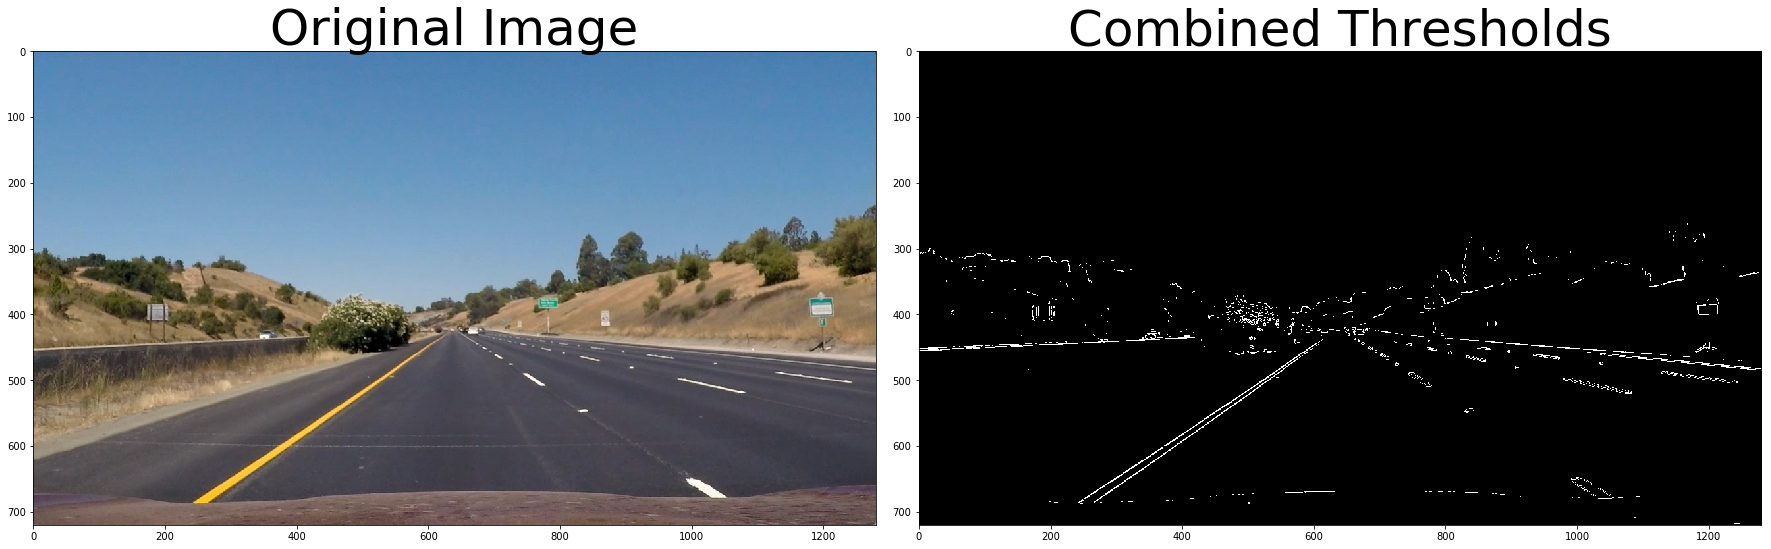

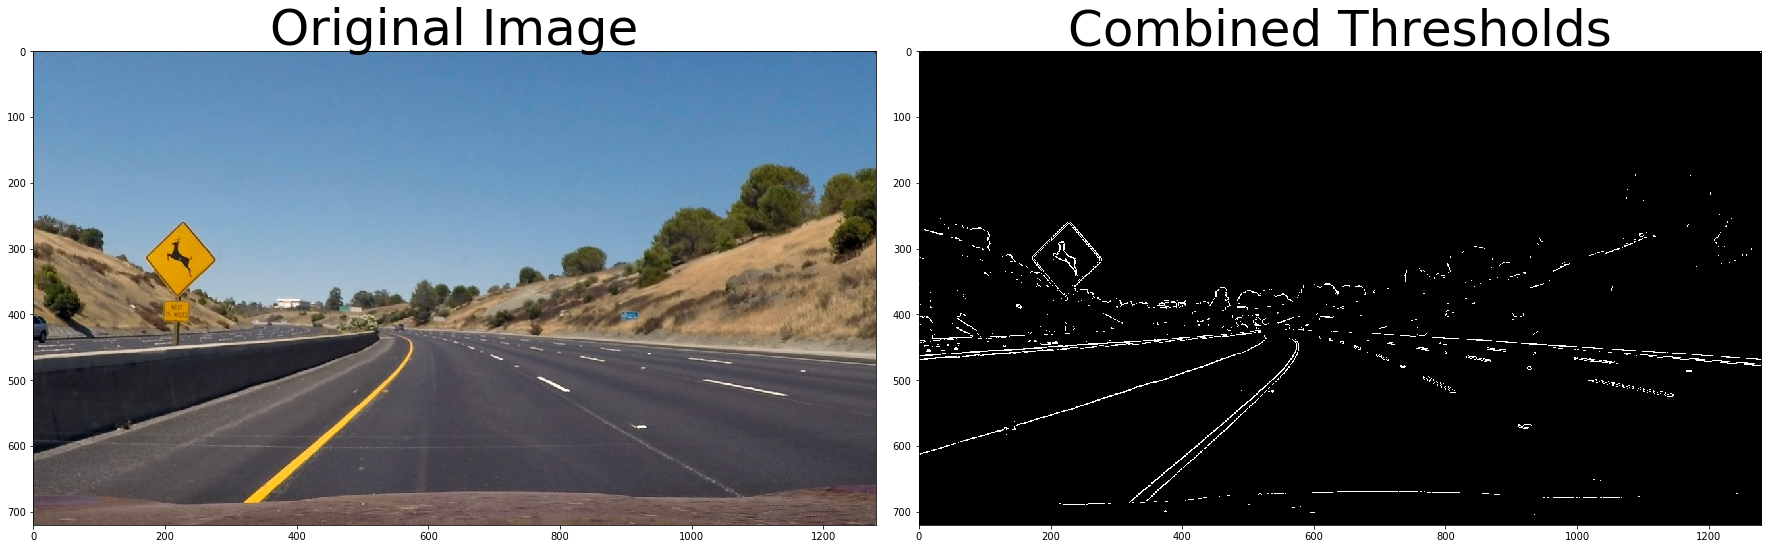

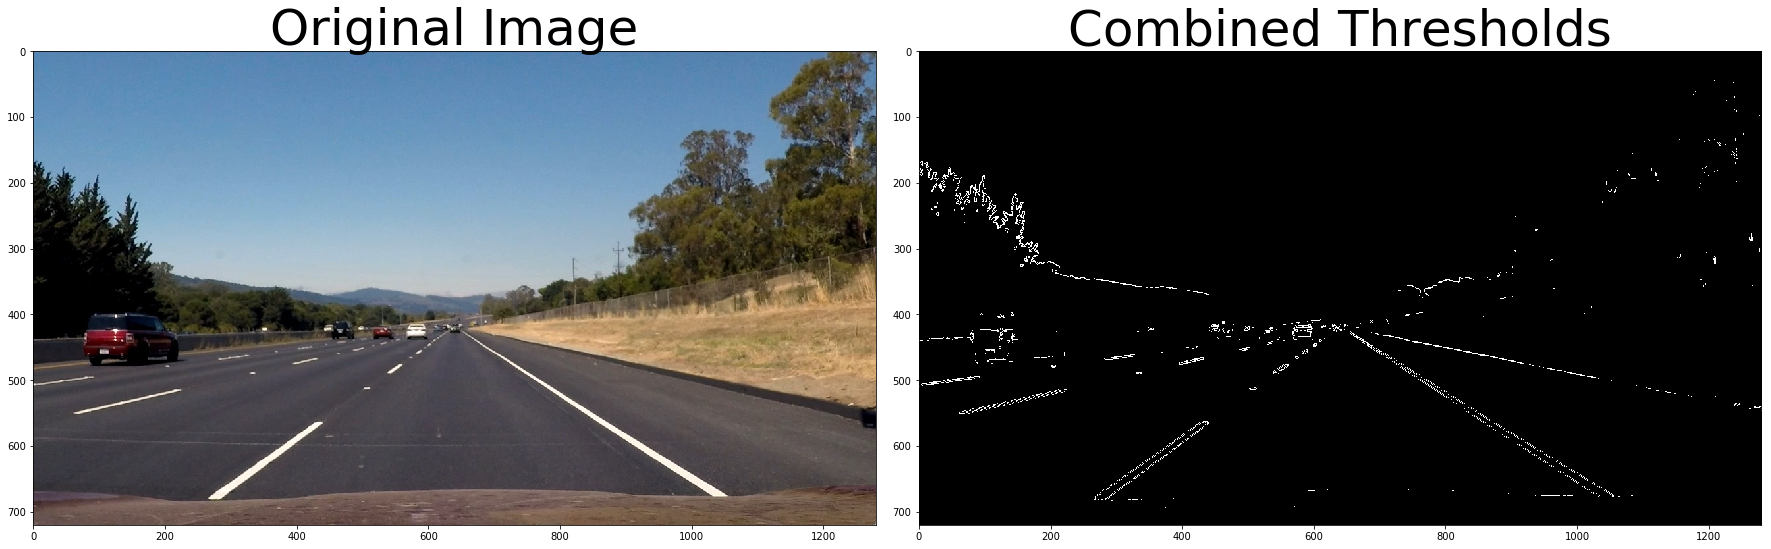

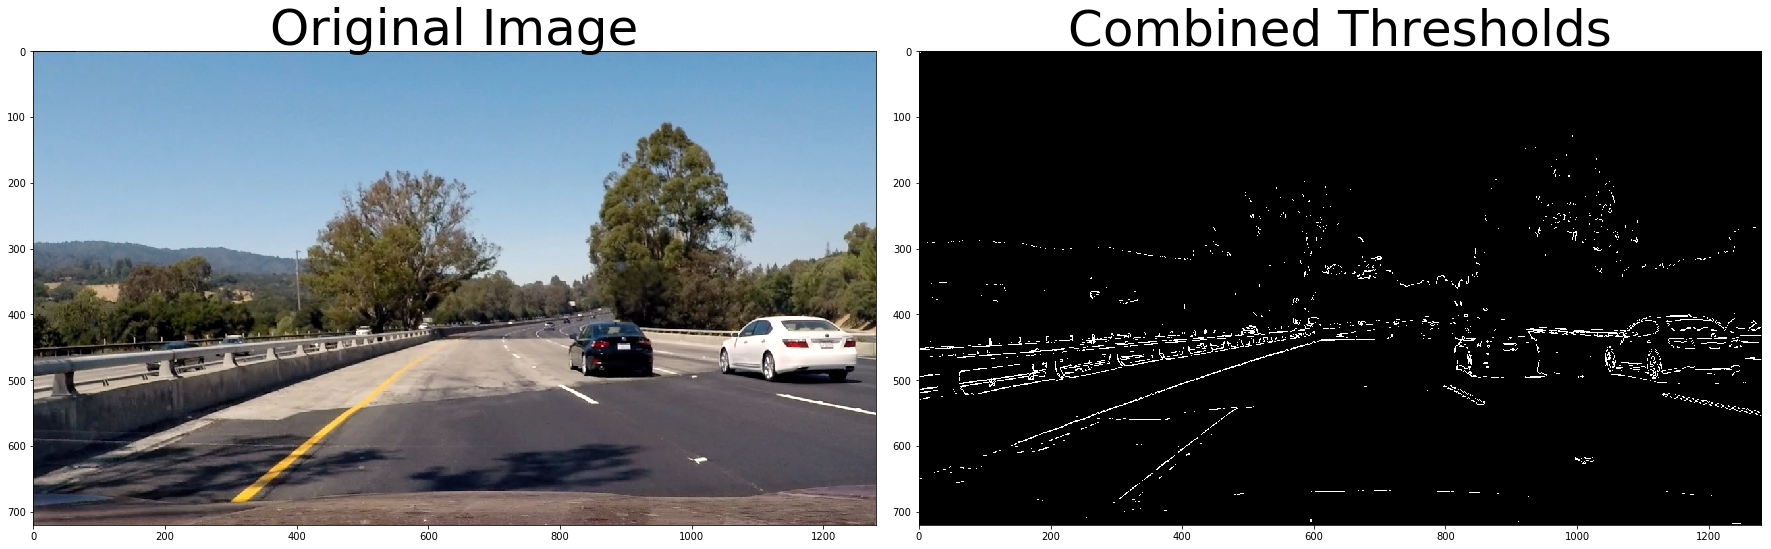

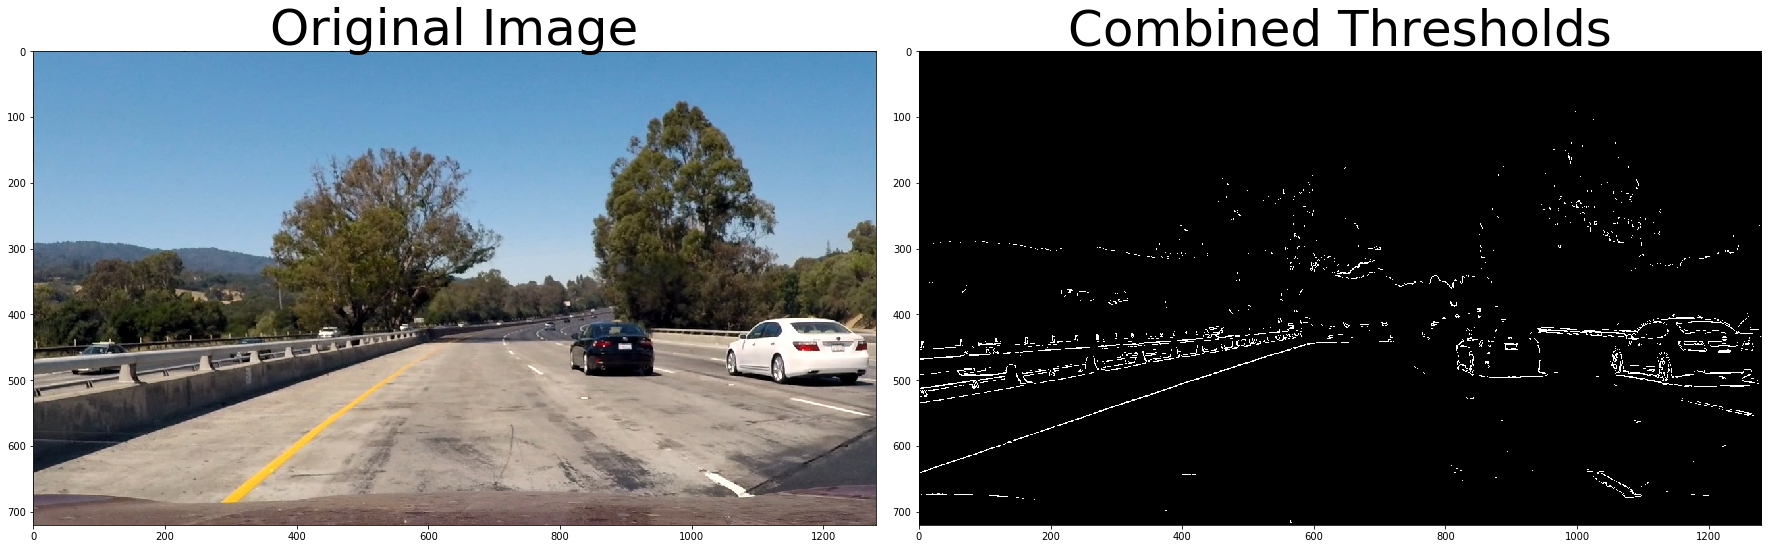

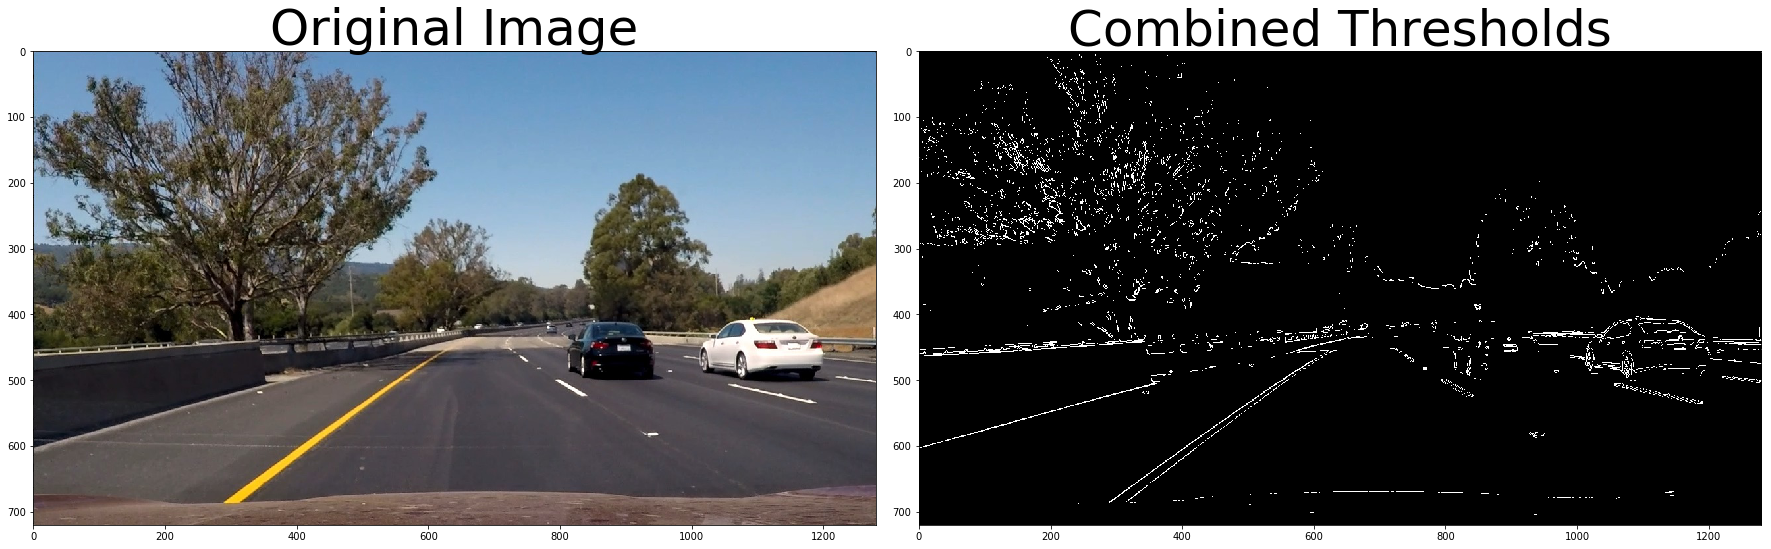

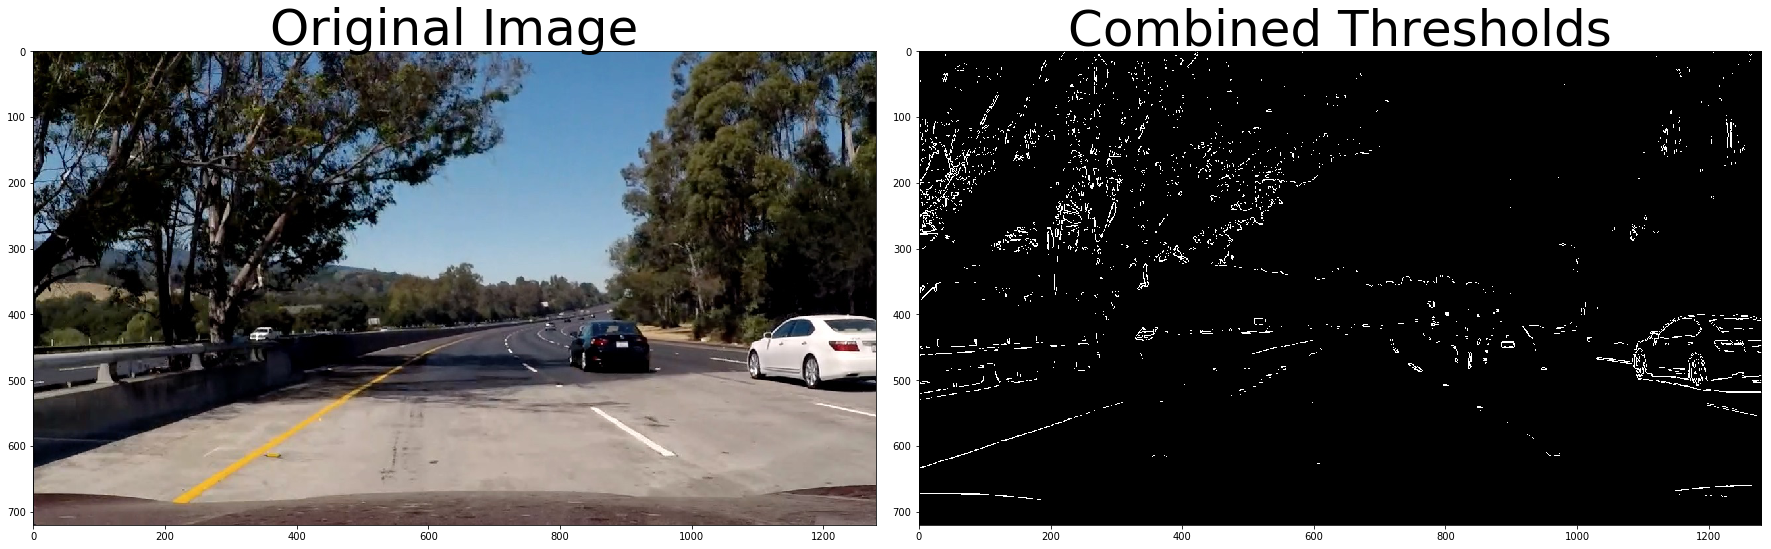

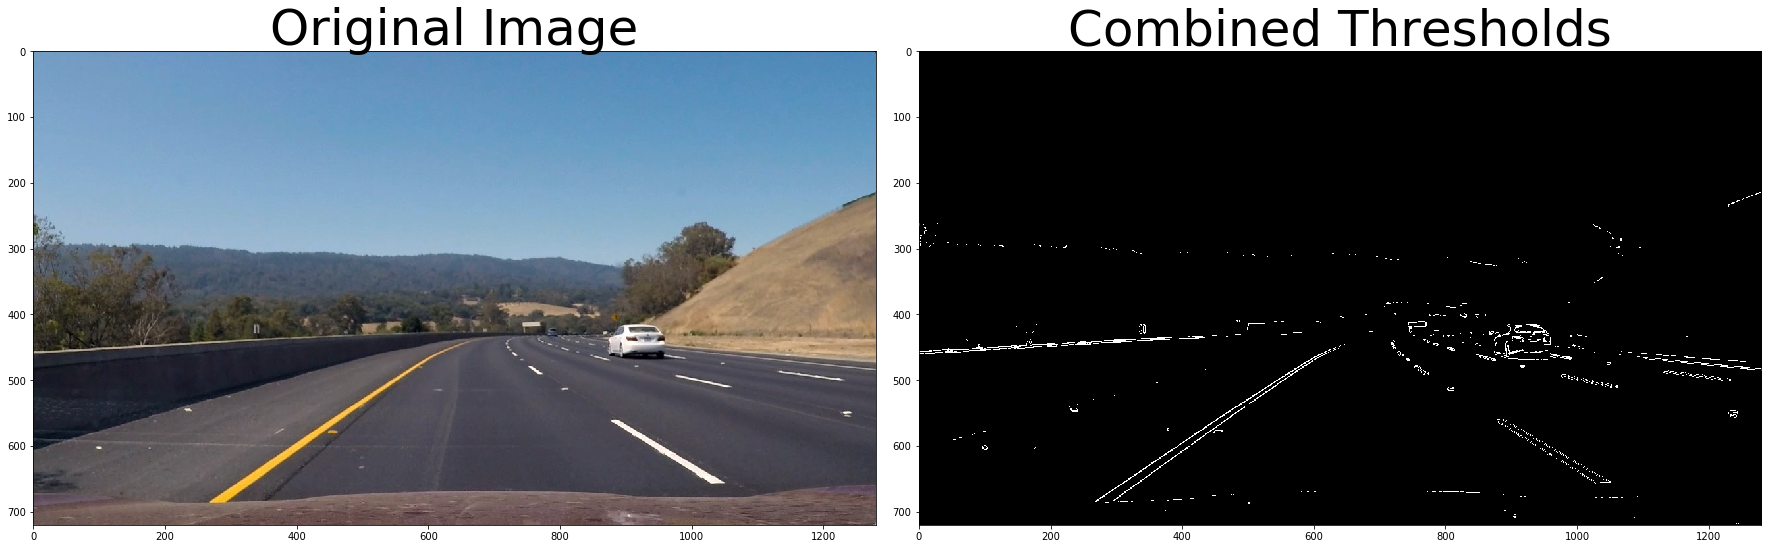

In [185]:
def main():
    
    advanced_lane_finding_pipeline()
    
main()